# Visualize Ensemble
### Erica Simon, 02/14/24
## Purpose: visualize output of probabilistic ensemble
load in temperature data from `.nc` file so simulation only needs to be run once


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns

## Globals

In [1]:
plots_dir = '../plots/'   #filepath to folder where saved plots are stored

In [2]:
weights_51yr = np.ones(52)
weights_51yr[0] = 0.5
weights_51yr[-1] = 0.5

In [3]:
scenario_order = ["Net Zero 2050", "Low demand", "Below 2 C", "Delayed transition", 
                  "Fragmented World", "NDCs", "Current Policies"]

In [4]:
NGFS_colors = {
    "Net Zero 2050": "#00a9cf",
    "Below 2 C": "#003466",
    "NDCs": "#f69320",
    "Current Policies": "#df0000",
    "Low demand": "#2274ae",
    "Fragmented World": "#b0724e",
    "Delayed transition": "#92397a",
}

In [5]:
models = {
    "GCAM 6.0 NGFS": "GCAM",
    "MESSAGEix-GLOBIOM": "MESSAGE",
    "REMIND-MAgPIE": "REMIND"
}

## Get datasets

In [6]:
# open temperature datasets
GCAM_temp = xr.open_dataset('../outputs/GCAM_temp.nc')
MSG_temp = xr.open_dataset('../outputs/MSG_temp.nc')
REM_temp = xr.open_dataset('../outputs/REM_temp.nc')

In [27]:
# open forcing datasets
GCAM_forc_sum = xr.open_dataset('../outputs/GCAM_forcing_sum.nc')
MSG_forc_sum = xr.open_dataset('../outputs/MSG_forcing_sum.nc')
REM_forc_sum = xr.open_dataset('../outputs/REM_forcing_sum.nc')

GCAM_forc = xr.open_dataset('../outputs/GCAM_forcing.nc')
MSG_forc = xr.open_dataset('../outputs/MSG_forcing.nc')
REM_forc = xr.open_dataset('../outputs/REM_forcing.nc')

In [28]:
# add model name to dataset
for ds in [GCAM_temp, GCAM_forc_sum, GCAM_forc]:
    ds.attrs['model'] = 'GCAM 6.0 NGFS'
    
for ds in [MSG_temp, MSG_forc_sum, MSG_forc]:
    ds.attrs['model'] = 'MESSAGEix-GLOBIOM'

    
for ds in [REM_temp, REM_forc_sum, REM_forc]:
    ds.attrs['model'] = 'REMIND-MAgPIE'

# Temperature

## Median

In [9]:
def calc_anomaly(ds, scen):
    return ds.temperature.loc[dict(scenario=scen, layer=0)]- np.average(
                        ds.temperature.loc[
                            dict(scenario=scen, timebounds=np.arange(1850, 1902), layer=0)
                        ],
                        weights=weights_51yr,
                        axis=0
                        )

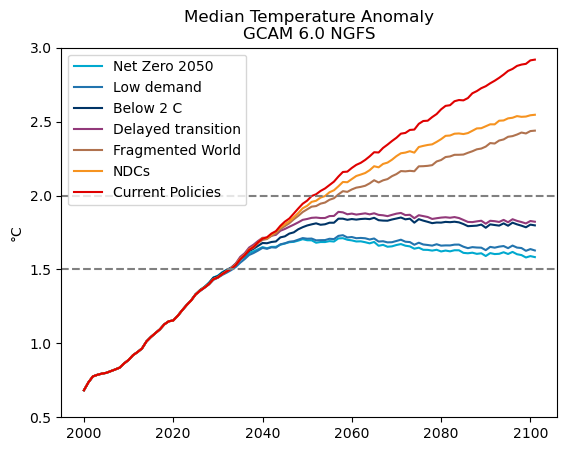

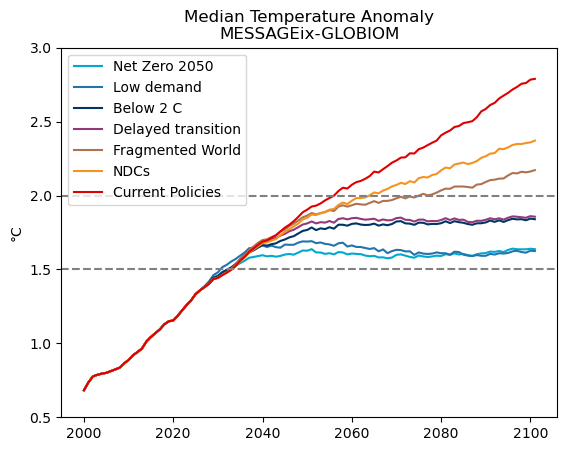

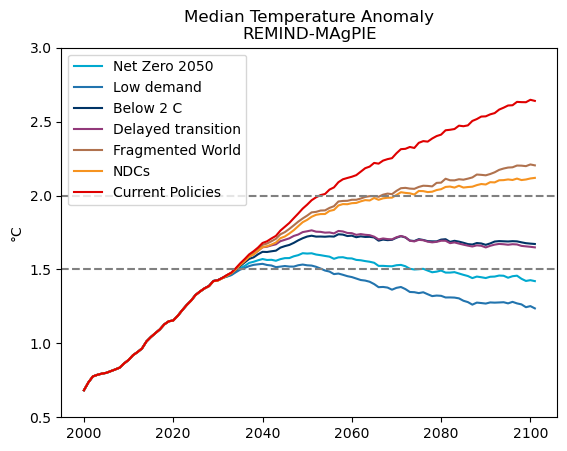

In [10]:
for ds in [GCAM_temp, MSG_temp, REM_temp]:
    for i, scenario in enumerate(scenario_order):
        plt.plot(ds.timebounds[250:], 
                 np.median(calc_anomaly(ds, scenario), axis=1)[250:], 
                 label=scenario, color=NGFS_colors[scenario])

    plt.legend()
    plt.ylabel('°C')
    plt.axhline(2, color='grey', linestyle='--')
    plt.axhline(1.5, color='grey', linestyle='--')
    plt.ylim(0.5,3)
    plt.title('Median Temperature Anomaly\n' + ds.model)

    plt.savefig(plots_dir + models[ds.model] + '/median_temp.png', bbox_inches='tight')
    plt.show()

## Visualize as Timeseries

In [11]:
def plot_scenarios(ds):
    fig, ax = plt.subplots(2, 4, figsize=(12, 6))

    for i, scenario in enumerate(scenario_order):
        for pp in ((0, 100), (5, 95), (16, 84)):
            ax[i // 4, i % 4].fill_between(
                ds.timebounds,
                np.percentile(
                    ds.temperature.loc[dict(scenario=scenario, layer=0)]
                    - np.average(
                        ds.temperature.loc[
                            dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                        ],
                        weights=weights_51yr,
                        axis=0
                    ),
                    pp[0],
                    axis=1,
                ),
                np.percentile(
                    ds.temperature.loc[dict(scenario=scenario, layer=0)]
                    - np.average(
                        ds.temperature.loc[
                            dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                        ],
                        weights=weights_51yr,
                        axis=0
                    ),
                    pp[1],
                    axis=1,
                ),
                color=NGFS_colors[scenario],
                alpha=0.2,
                lw=0
            )

        ax[i // 4, i % 4].plot(
            ds.timebounds,
            np.median(
                ds.temperature.loc[dict(scenario=scenario, layer=0)]
                - np.average(
                    ds.temperature.loc[
                        dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                    ],
                    weights=weights_51yr,
                    axis=0
                ),
                axis=1,
            ),
            color=NGFS_colors[scenario],
        )
        ax[i // 4, i % 4].set_xlim(1850, 2100)
        ax[i // 4, i % 4].set_ylim(-1, 6)
        ax[i // 4, i % 4].axhline(0, color="k", ls=":", lw=0.5)
        ax[i // 4, i % 4].set_title(scenario)

    plt.suptitle(ds.model + ': Temperature Anomalies')
    fig.supylabel('℃')
    fig.tight_layout()
    plt.savefig(plots_dir + models[ds.model] + '/prob_temp_timeseries.png')

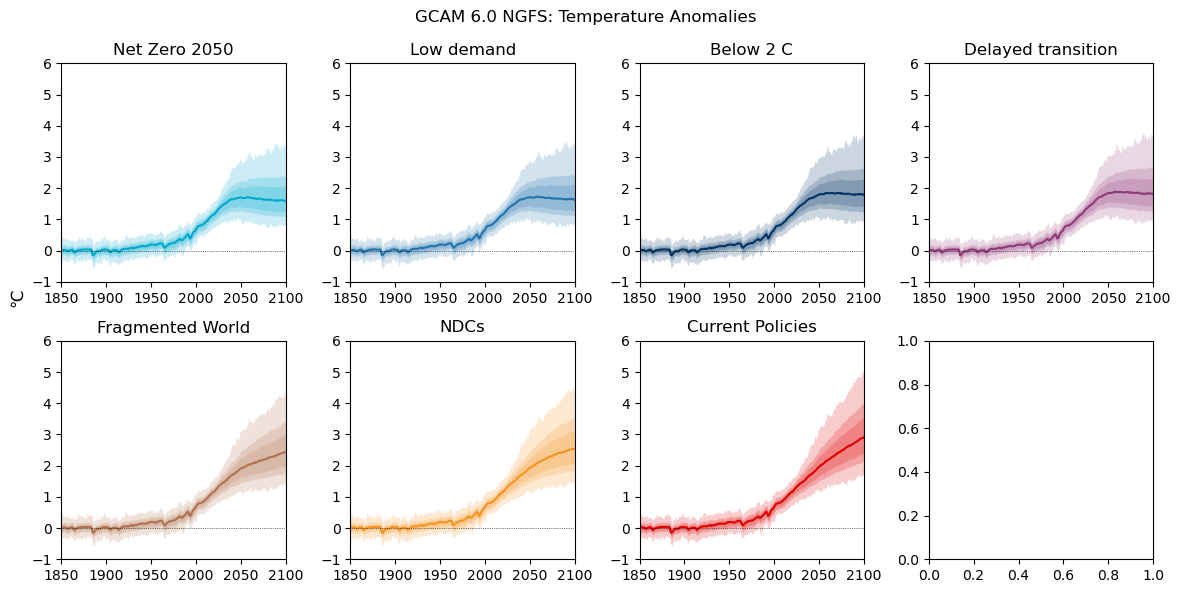

In [12]:
plot_scenarios(GCAM_temp)

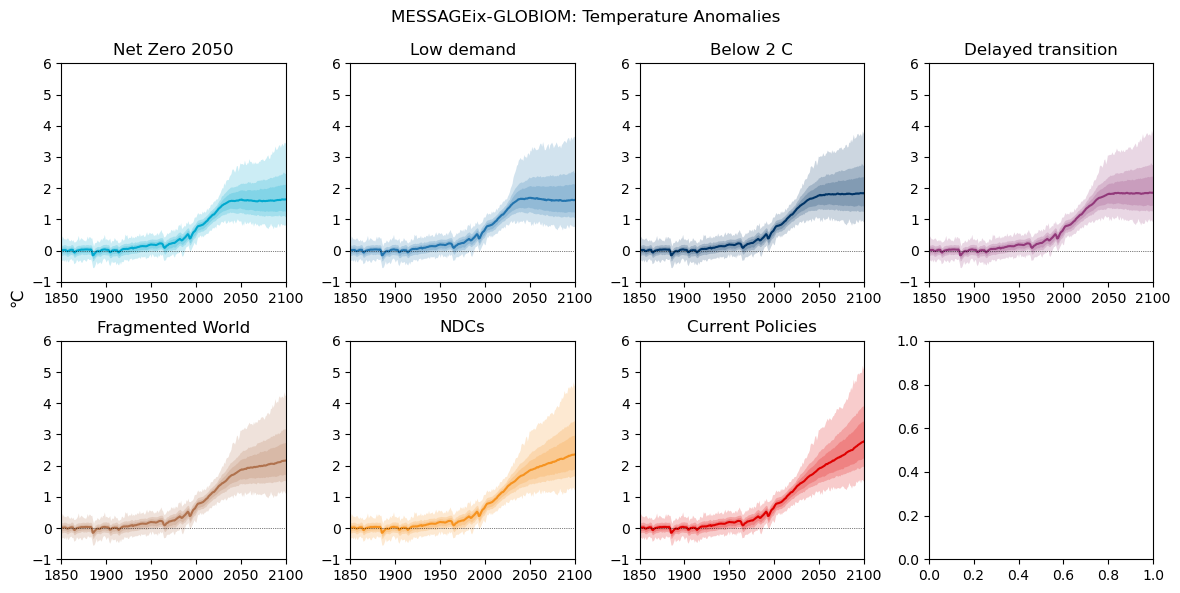

In [13]:
plot_scenarios(MSG_temp)

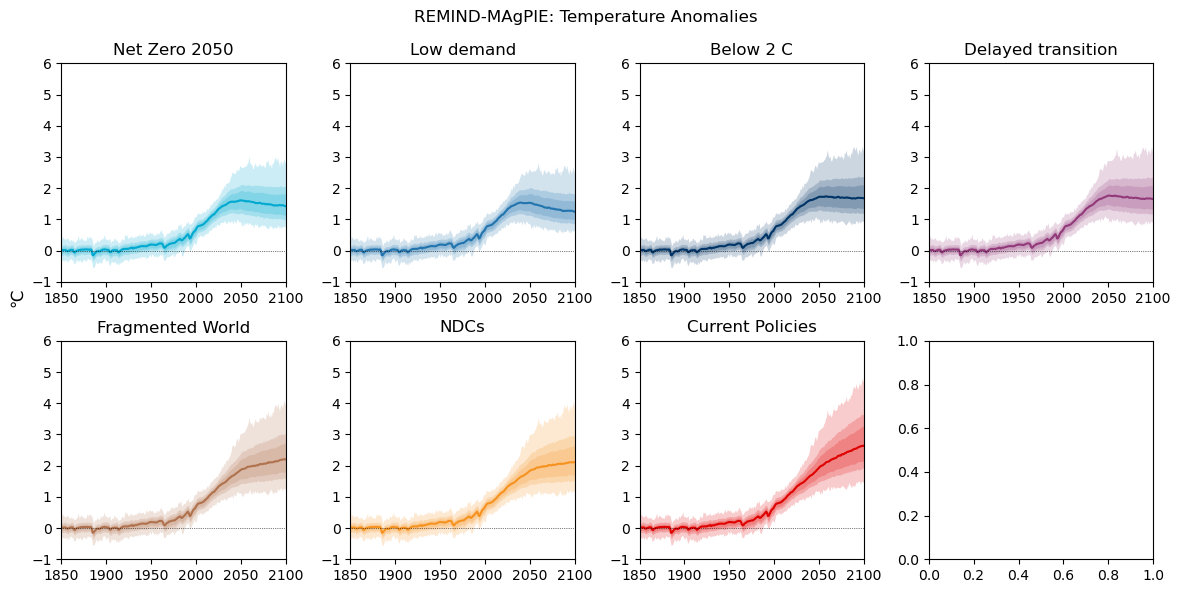

In [14]:
plot_scenarios(REM_temp)

## Visualize Single Year

In [15]:
def plt_temp_distribs(ds, year, xmax=5, ymax=1.4):

    fig, ax = plt.subplots(2, 4, figsize=(12, 6))

    for i, scenario in enumerate(scenario_order):
        r, c = divmod(i, 4)
        
        temp_anom = ds.temperature.loc[dict(scenario=scenario, layer=0, timebounds=year)]- np.average(
                        ds.temperature.loc[
                            dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                        ],
                        weights=weights_51yr,
                        axis=0
                    )

        sns.kdeplot(temp_anom, ax=ax[r,c], color=NGFS_colors[scenario], fill=True, alpha=0.5)
        ax[r,c].set_title(scenario)
        ax[r,c].set_xlim(0, xmax)
        ax[r,c].set_ylim(0, ymax)

    plt.suptitle("Distribution of Temperature Anomalies in " + str(year) + '\n' + ds.model)
    fig.supxlabel('℃')
    
    fig.tight_layout()
    
    # save plot
    plt.savefig(plots_dir + models[ds.model] + '/temp_pdf_' + str(year) + '.png')
    
    # close to prevent plot from showing- possible to uncomment and view all plots
    plt.close()

In [16]:
for ds in [GCAM_temp, REM_temp, MSG_temp]:
    plt_temp_distribs(ds, 2030, ymax=2.5, xmax=5)
    plt_temp_distribs(ds, 2040, ymax=2.5, xmax=5)
    plt_temp_distribs(ds, 2050, ymax=2.5, xmax=5)    
    plt_temp_distribs(ds, 2100, ymax=2.5, xmax=5)    

### investigation irregular distribution- plotting hist

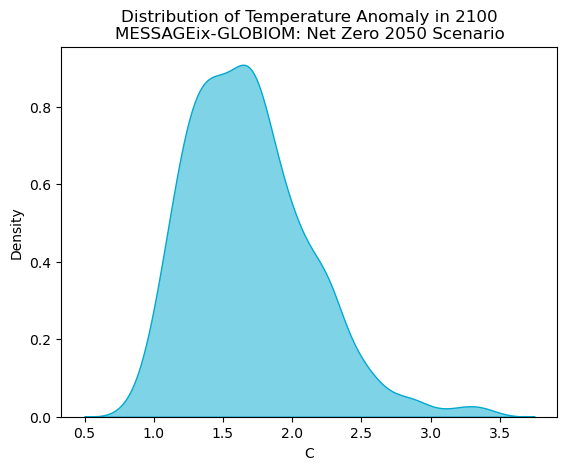

In [17]:
t = MSG_temp.temperature.loc[dict(scenario='Net Zero 2050', layer=0, timebounds=2100)]- np.average(
                        MSG_temp.temperature.loc[
                            dict(scenario='Net Zero 2050', timebounds=np.arange(1850, 1902), layer=0)
                        ],
                        weights=weights_51yr,
                        axis=0
                    )


sns.kdeplot(t, color=NGFS_colors['Net Zero 2050'], fill=True, alpha=0.5)
plt.xlabel('C')
plt.title('Distribution of Temperature Anomaly in 2100\nMESSAGEix-GLOBIOM: Net Zero 2050 Scenario')
plt.show()

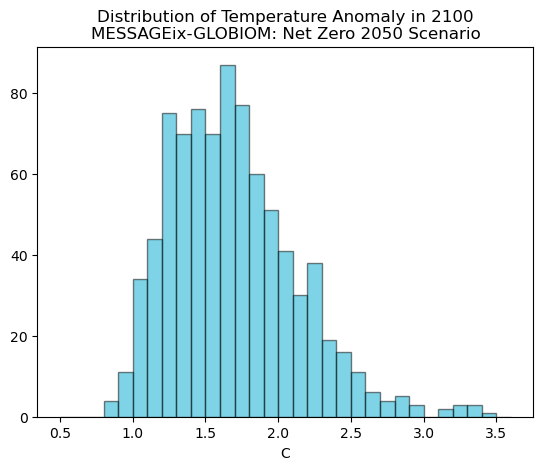

In [18]:
b = np.arange(0.5, 3.7, 0.1)  # bins for histogram

plt.hist(t, color=NGFS_colors['Net Zero 2050'], alpha=0.5, edgecolor='black', bins=b)
plt.xlabel('C')
plt.title('Distribution of Temperature Anomaly in 2100\nMESSAGEix-GLOBIOM: Net Zero 2050 Scenario')
plt.show()

## Calculate Percentiles

In [19]:
def get_percentile(ds, year, lower_perc, upper_perc):
    
    perc_dict = {}

    for scenario in scenario_order:
        
        temp_anom = ds.temperature.loc[dict(scenario=scenario, layer=0, timebounds=year)]- np.average(
                        ds.temperature.loc[
                            dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                        ],
                        weights=weights_51yr,
                        axis=0
                    )
        
        a = round(np.percentile(temp_anom, lower_perc), 2)
        b = round(np.percentile(temp_anom, upper_perc), 2)
        
        perc_dict[scenario] = [a, b]
    
    return perc_dict

In [20]:
get_percentile(GCAM_temp, 2100, 25, 75)

{'Net Zero 2050': [1.33, 1.88],
 'Low demand': [1.36, 1.94],
 'Below 2 C': [1.51, 2.12],
 'Delayed transition': [1.53, 2.14],
 'Fragmented World': [2.12, 2.83],
 'NDCs': [2.2, 2.95],
 'Current Policies': [2.54, 3.36]}

In [21]:
get_percentile(REM_temp, 2100, 25, 75)

{'Net Zero 2050': [1.22, 1.68],
 'Low demand': [1.06, 1.47],
 'Below 2 C': [1.44, 1.96],
 'Delayed transition': [1.41, 1.93],
 'Fragmented World': [1.91, 2.55],
 'NDCs': [1.81, 2.46],
 'Current Policies': [2.29, 3.06]}

In [22]:
get_percentile(MSG_temp, 2100, 25, 75)

{'Net Zero 2050': [1.36, 1.94],
 'Low demand': [1.32, 1.94],
 'Below 2 C': [1.53, 2.17],
 'Delayed transition': [1.54, 2.19],
 'Fragmented World': [1.83, 2.55],
 'NDCs': [2.0, 2.78],
 'Current Policies': [2.39, 3.24]}

## Plot Tails (nth percentile)

In [23]:
def plt_temp_kde_tail(ds, year, lower_perc=95, upper_perc=100, xmin=2, xmax=5.3, ylim=0.3):

    fig, ax = plt.subplots(2, 4, figsize=(12, 6))

    for i, scenario in enumerate(scenario_order):
        r, c = divmod(i, 4)
        
        temp_anom = ds.temperature.loc[dict(scenario=scenario, layer=0, timebounds=year)]- np.average(
                        ds.temperature.loc[
                            dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                        ],
                        weights=weights_51yr,
                        axis=0
                    )
        
        a = np.percentile(temp_anom, lower_perc)
        b = np.percentile(temp_anom, upper_perc)

        sns.kdeplot(temp_anom, ax=ax[r,c], color=NGFS_colors[scenario], fill=True, alpha=0.5, clip=(a,b))
        ax[r,c].set_title(scenario)
        ax[r,c].set_xlim(xmin, xmax)
        ax[r,c].set_ylim(0, ylim)
        # ax[r,c].axvline(a, color="k", ls=":", lw=0.5)

    plt.suptitle(str(lower_perc) + "th percentile of Temperature Anomalies in " + str(year) + '\n' + ds.model)
    fig.supxlabel('℃')
    fig.tight_layout()
    
    # save plot
    plt.savefig(plots_dir + models[ds.model] + '/temp_tail_' + str(year) + '.png')
    
    # close to prevent plot from showing- can uncomment to view all plots
    plt.close()

In [24]:
for ds in [GCAM_temp, REM_temp, MSG_temp]:
    plt_temp_kde_tail(ds, 2030, xmin=1.7, xmax=2.2, ylim=0.6)
    plt_temp_kde_tail(ds, 2040, xmin=2, xmax=2.7, ylim=0.5)
    plt_temp_kde_tail(ds, 2050, xmin=2, xmax=3.3, ylim=0.4)
    plt_temp_kde_tail(ds, 2100, xmin=1.8, xmax=5.3, ylim=0.3)  

# Forcing

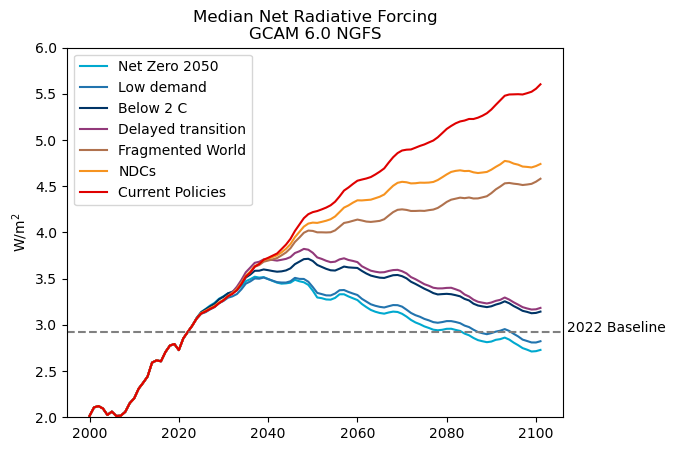

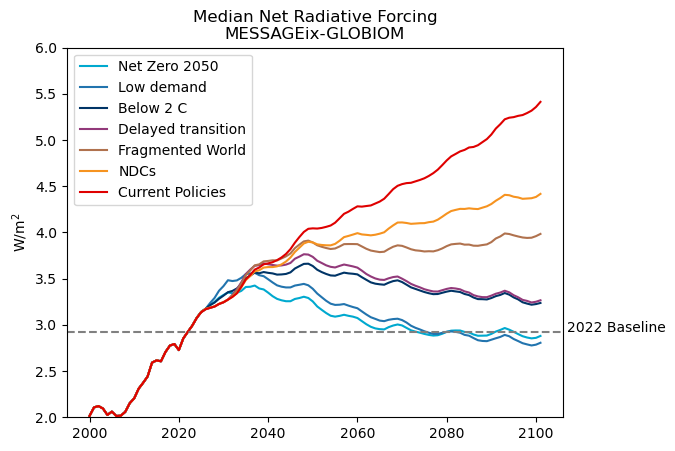

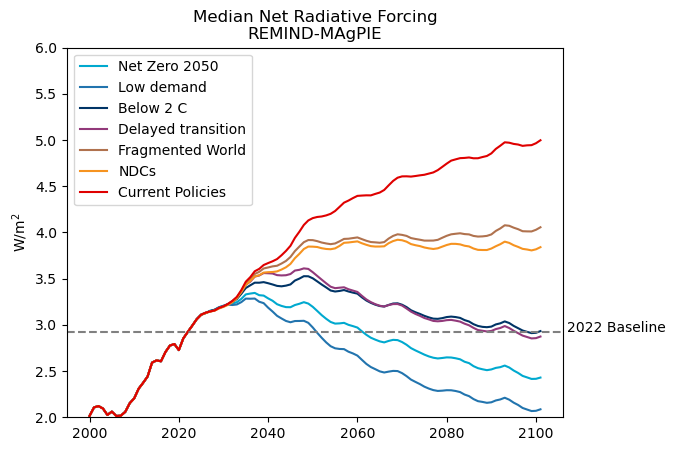

In [25]:
for ds in [GCAM_forc_sum, MSG_forc_sum, REM_forc_sum]:
    for i, scenario in enumerate(scenario_order):
        plt.plot(ds.timebounds[250:], 
                 np.median(ds.forcing.loc[dict(scenario=scenario)], axis=1)[250:], 
                 label=scenario, color=NGFS_colors[scenario])

    val = np.median(ds.forcing.loc[dict(scenario=scenario)], axis=1)[272]  # median value for 2022
    plt.axhline(val, color='grey', linestyle='--')
    plt.text(2107, val, '2022 Baseline')

    plt.ylim(2,6)
    plt.legend()
    plt.ylabel('W/m$^2$')
    plt.title('Median Net Radiative Forcing\n' + ds.model)

    plt.savefig(plots_dir + models[ds.model] + '/median_forcing.png', bbox_inches='tight')
    plt.show()

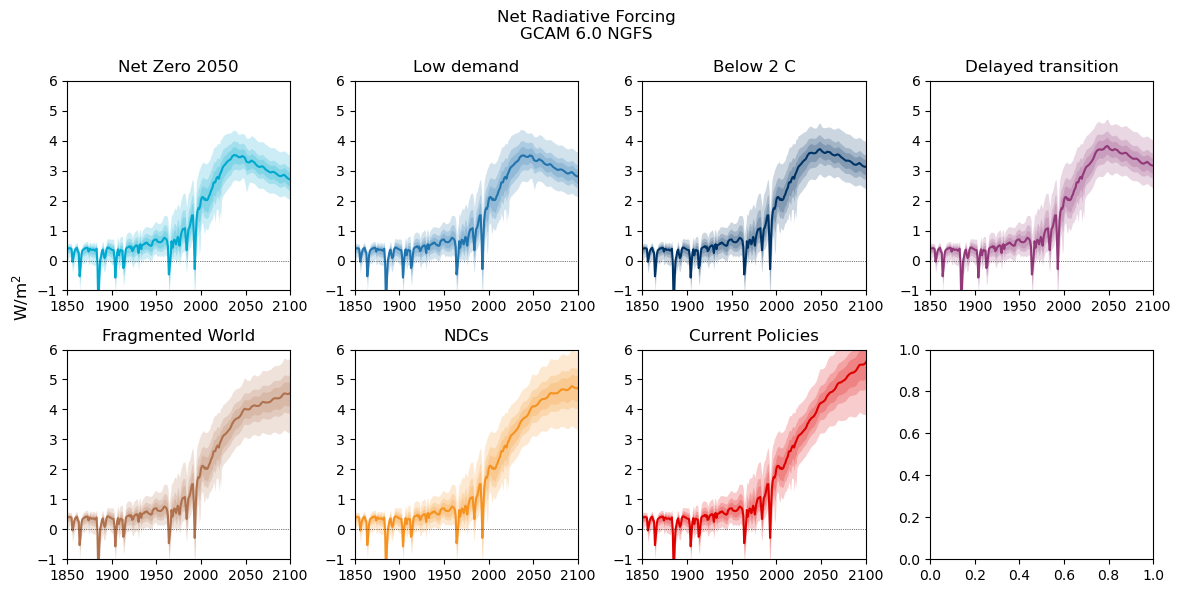

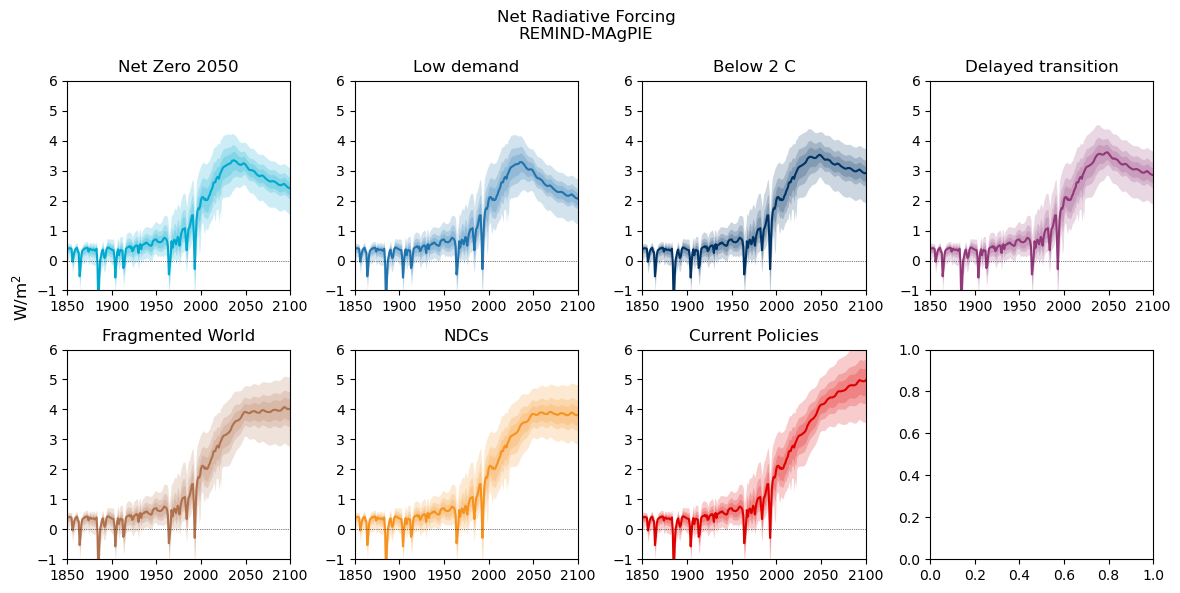

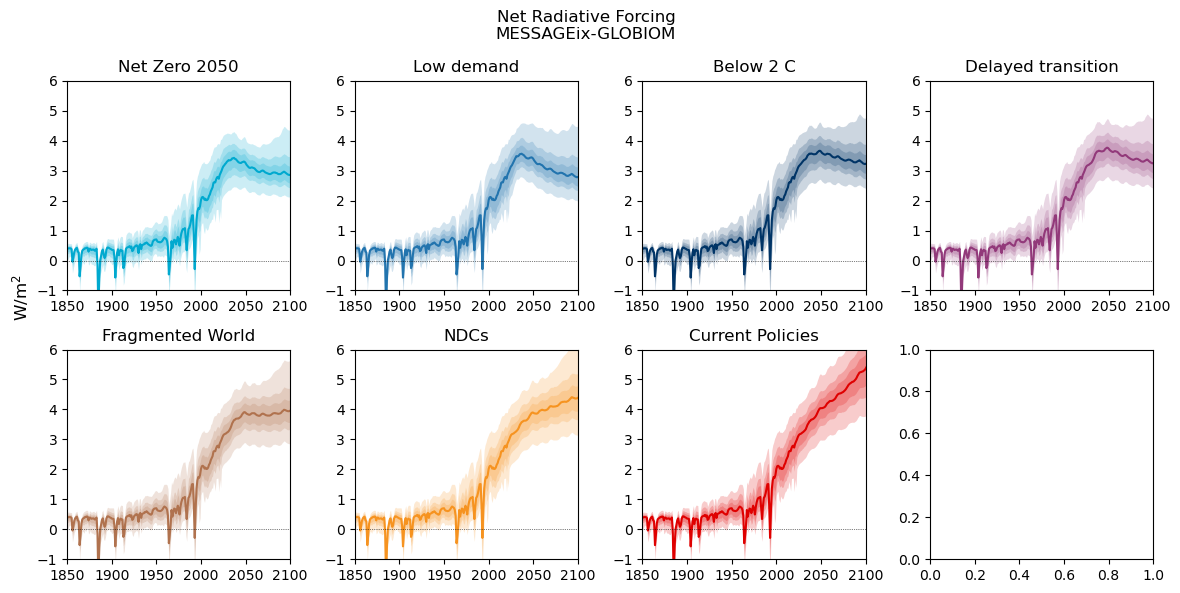

In [38]:
for ds in [GCAM_forc_sum, REM_forc_sum, MSG_forc_sum]:
    fig, ax = plt.subplots(2, 4, figsize=(12, 6))

    for i, scenario in enumerate(scenario_order):
        for pp in ((0, 100), (5, 95), (16, 84)):
            ax[i // 4, i % 4].fill_between(
                ds.timebounds,
                np.percentile(
                    ds.forcing.loc[dict(scenario=scenario)],
                    pp[0],
                    axis=1,
                ),
                np.percentile(
                    ds.forcing.loc[dict(scenario=scenario)],
                    pp[1],
                    axis=1,
                ),
                color=NGFS_colors[scenario],
                alpha=0.2,
                lw=0
            )

        ax[i // 4, i % 4].plot(
            ds.timebounds,
            np.median(
                ds.forcing.loc[dict(scenario=scenario)],
                axis=1,
            ),
            color=NGFS_colors[scenario],
        )
        ax[i // 4, i % 4].set_xlim(1850, 2100)
        ax[i // 4, i % 4].set_ylim(-1, 6)
        ax[i // 4, i % 4].axhline(0, color="k", ls=":", lw=0.5)
        ax[i // 4, i % 4].set_title(scenario)

    plt.suptitle('Net Radiative Forcing\n' + ds.model)
    fig.supylabel('W/m$^2$')
    fig.tight_layout()

    plt.savefig(plots_dir + models[ds.model] + '/prob_forcing_timeseries.png')